In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-classification-finetuning/sample_submission.csv
/kaggle/input/llm-classification-finetuning/train.csv
/kaggle/input/llm-classification-finetuning/test.csv


The competition dataset consists of user interactions from the ChatBot Arena. In each user interaction a judge provides one or more prompts to two different LLMs, and then indicates which of the models gave the more satisfactory response. The goal of the competition is to **predict the preferences of the judges** and **determine the likelihood that a given prompt/response pair is selected as the winner**.

Please note that this is a Code Competition. When your submission is scored, this example test data will be replaced with the full test set. There are **55K rows in the training data**, and you can expect roughly **25,000 rows in the test set**.

train.csv

* id - A unique identifier for the row.
* model_[a/b] - The identity of model_[a/b]. Included in train.csv but not test.csv.
* prompt - The prompt that was given as an input (to both models).
* response_[a/b] - The response from model_[a/b] to the given prompt.
* winner_model_[a/b/tie] - Binary columns marking the judge's selection. The ground truth target column.

# Define the problem:
* Problem Type: multinomial classification problem (who wins" A, B, Tie)
* Output: prdict the likeihood (probability)


==> Which Model?
classification problem:
logistic regression, decision tree, random forest, XGBoost, LightGBM, neural network

We can chooose the model in after observing the data type.

In [2]:
train_file_path='/kaggle/input/llm-classification-finetuning/train.csv'
train_df=pd.read_csv(train_file_path)
train_df=pd.DataFrame(train_df)
print(train_df)

               id             model_a              model_b  \
0           30192  gpt-4-1106-preview           gpt-4-0613   
1           53567           koala-13b           gpt-4-0613   
2           65089  gpt-3.5-turbo-0613       mistral-medium   
3           96401    llama-2-13b-chat  mistral-7b-instruct   
4          198779           koala-13b   gpt-3.5-turbo-0314   
...           ...                 ...                  ...   
57472  4294656694          gpt-4-0613             claude-1   
57473  4294692063          claude-2.0     llama-2-13b-chat   
57474  4294710549            claude-1           alpaca-13b   
57475  4294899228              palm-2       tulu-2-dpo-70b   
57476  4294947231  gemini-pro-dev-api   gpt-4-1106-preview   

                                                  prompt  \
0      ["Is it morally right to try to have a certain...   
1      ["What is the difference between marriage lice...   
2      ["explain function calling. how would you call...   
3      ["How ca

In [3]:
train_df.describe()

,id,winner_model_a,winner_model_b,winner_tie
count,5.747700e+04,57477.000000,57477.000000,57477.000000
mean,2.142564e+09,0.349079,0.341911,0.309011
std,1.238327e+09,0.476683,0.474354,0.462090
min,3.019200e+04,0.000000,0.000000,0.000000
25%,1.071821e+09,0.000000,0.000000,0.000000
50%,2.133658e+09,0.000000,0.000000,0.000000
75%,3.211645e+09,1.000000,1.000000,1.000000
max,4.294947e+09,1.000000,1.000000,1.000000


# Understanding the Data

- Data Size: Medium Size
    - 55K rows in the training data
    - roughly 25k rows in the test set.
    ==> 10k-1M rows (medium)
    ==> features space: 5 features (<100 = small, low dimention)
- Data type:Semi-structured
    - structured: winner model, model type(a/b)
    - unstructured: prompt/response
==> logistic regression as baseline

# Baseline

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [5]:
train_df

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0
...,...,...,...,...,...,...,...,...,...
57472,4294656694,gpt-4-0613,claude-1,"[""A simple mnemonic for \u03c0:\n\""How I wish ...","[""Sure, let's break it down:\n\n1. \""How\"" has...","[""Here is how that mnemonic represents the dig...",1,0,0
57473,4294692063,claude-2.0,llama-2-13b-chat,"[""In python, implement a naive Bayes with gaus...","[""Here is an implementation of a naive Bayes c...","[""Sure! Here's an implementation of a naive Ba...",1,0,0
57474,4294710549,claude-1,alpaca-13b,"[""is it unethical to work on building weapons?...","[""Working on weapons technology raises some et...","[""It depends on the context. Weapons can be us...",1,0,0
57475,4294899228,palm-2,tulu-2-dpo-70b,"[""If a bait contains 0,0025% bromadiolon then ...","[""Bromadiolone is a rodenticide which is most ...","[""As an AI language model, I do not promote or...",0,1,0


In [6]:
from scipy.sparse import hstack

In [7]:
#transfer the unstructured data(prompt/response's text)
vectorizer = TfidfVectorizer(max_features=1000)
vectorizer.fit(pd.concat([train_df['prompt'],train_df['response_a'],train_df['response_b'] ]))

prompt_tfidf = vectorizer.fit_transform(train_df['prompt'])
responseA_tfidf=vectorizer.fit_transform(train_df['response_a'])
responseB_tfidf=vectorizer.fit_transform(train_df['response_b'])

X_train=hstack([prompt_tfidf,responseA_tfidf,responseB_tfidf])

In [8]:
#Transfer the y_label data: 0=a, 1=b, 2=tie
train_df['label'] = np.select( 
    [
        train_df['winner_model_a'] == 1,
        train_df['winner_model_b'] == 1,
        train_df['winner_tie'] == 1
    ], 
        [0, 1, 2]
)

y_train=train_df['label']

In [9]:
#Train the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [10]:
import joblib

In [11]:
joblib.dump(model, 'logistic_regression.pkl')
model = joblib.load('logistic_regression.pkl')

In [12]:
#probability
X_train_proba=model.predict_proba(X_train)
print(X_train_proba.round(2))

[[0.86 0.04 0.1 ]
 [0.23 0.54 0.23]
 [0.33 0.42 0.25]
 ...
 [0.67 0.13 0.2 ]
 [0.27 0.36 0.37]
 [0.19 0.4  0.41]]


test.csv

* id
* prompt
* response_[a/b]


In [13]:
y_train_pred=model.predict(X_train)

In [14]:
#Test data
test_file_path='/kaggle/input/llm-classification-finetuning/test.csv'
test_df=pd.read_csv(test_file_path)
test_df=pd.DataFrame(test_df)
print(test_df)

        id                                             prompt  \
0   136060  ["I have three oranges today, I ate an orange ...   
1   211333  ["You are a mediator in a heated political deb...   
2  1233961  ["How to initialize the classification head wh...   

                                          response_a  \
0                    ["You have two oranges today."]   
1  ["Thank you for sharing the details of the sit...   
2  ["When you want to initialize the classificati...   

                                          response_b  
0  ["You still have three oranges. Eating an oran...  
1  ["Mr Reddy and Ms Blue both have valid points ...  
2  ["To initialize the classification head when p...  


In [15]:
test_prompt_tfidf = vectorizer.transform(test_df['prompt'])
test_responseA_tfidf = vectorizer.transform(test_df['response_a'])
test_responseB_tfidf = vectorizer.transform(test_df['response_b'])

X_test=hstack([test_prompt_tfidf,test_responseA_tfidf,test_responseB_tfidf])

In [16]:
#probability
print(model.predict_proba(X_test).round(2))

[[0.2  0.49 0.31]
 [0.89 0.03 0.08]
 [0.22 0.53 0.26]]


In [17]:
y_test_pred=model.predict(X_test)

# Evaluate Performance Metrics:

Define the evaluation metrics that are most important for your problem. Accuracy, precision, recall, F1-score, or area under the ROC curve are commonly used metrics. Different models may perform better or worse depending on the chosen metric. Additionally, consider if class imbalance or other specific challenges in your dataset require customized metrics.

In [18]:
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, classification_report

In [19]:
# logloss: The less is better
logloss_logistic = log_loss(y_train, X_train_proba)
print(f"Logloss: {logloss_logistic:.4f}")

# accuracy
acc_logistic  = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {acc_logistic:.4f}")

# precision / recall / f1-score:
print("Classification Report:")
print(classification_report(y_train, y_train_pred, digits=4))


Logloss: 0.9845
Accuracy: 0.5155
Classification Report:
              precision    recall  f1-score   support

           0     0.5206    0.5704    0.5444     20064
           1     0.5161    0.5506    0.5328     19652
           2     0.5071    0.4148    0.4563     17761

    accuracy                         0.5155     57477
   macro avg     0.5146    0.5119    0.5112     57477
weighted avg     0.5149    0.5155    0.5132     57477



In [20]:
from collections import defaultdict

In [21]:
evaluated_model = defaultdict(dict)
evaluated_model['logistic regression']['logloss'] = logloss_logistic 
evaluated_model['logistic regression']['accuracy'] = acc_logistic 

evaluated_table=pd.DataFrame(evaluated_model)
evaluated_table

,logistic regression
logloss,0.984516
accuracy,0.515545


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

Confusion Matrix:
[[11445  5029  3590]
 [ 5261 10820  3571]
 [ 5280  5114  7367]]


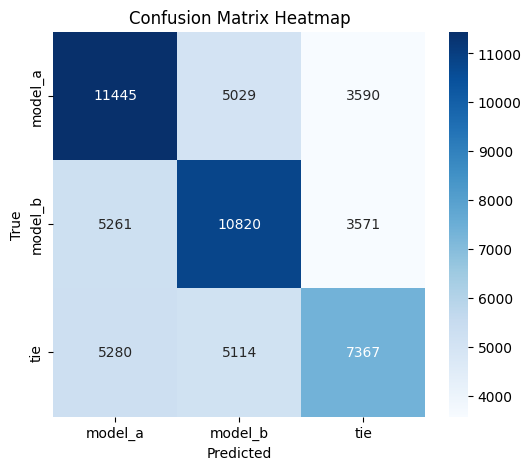

In [23]:
cm_logistic = confusion_matrix(y_train, y_train_pred)

print("Confusion Matrix:")
print(cm_logistic )

labels = ['model_a', 'model_b', 'tie']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_logistic , annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

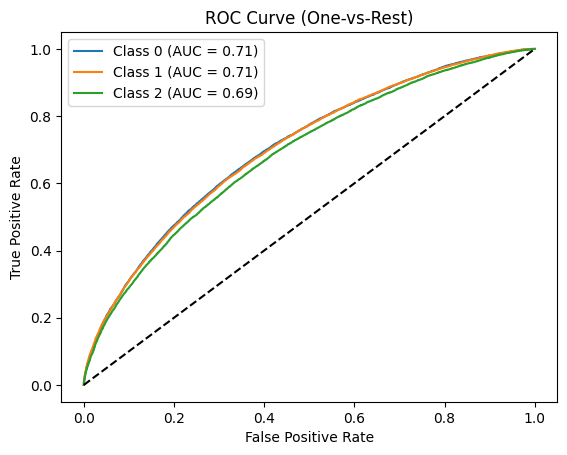

In [24]:
from sklearn.metrics import roc_curve, auc

n_classes = 3 #len(np.unique(y_train))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_train == i).astype(int), X_train_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()


# Advanced Model

Let's try the Gradient Boost Tree (XGBoost)

In [25]:
from xgboost import XGBClassifier

In [26]:
model = XGBClassifier(
    objective='multi:softprob',
    num_class=3 ,#len(np.unique(y_train))
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)
y_train_proba = model.predict_proba(X_train)
y_train_pred = model.predict(X_train)

In [27]:
joblib.dump(model, 'xgboost.pkl')
model = joblib.load('xgboost.pkl')

Logloss: 0.8156
Accuracy: 0.7216
Classification Report:
              precision    recall  f1-score   support

           0     0.7094    0.7720    0.7394     20064
           1     0.7224    0.7483    0.7351     19652
           2     0.7378    0.6350    0.6825     17761

    accuracy                         0.7216     57477
   macro avg     0.7232    0.7184    0.7190     57477
weighted avg     0.7226    0.7216    0.7204     57477

Confusion Matrix:
[[15490  2591  1983]
 [ 2922 14705  2025]
 [ 3424  3059 11278]]


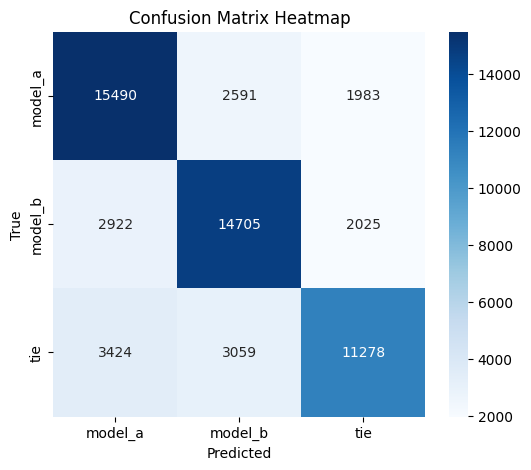

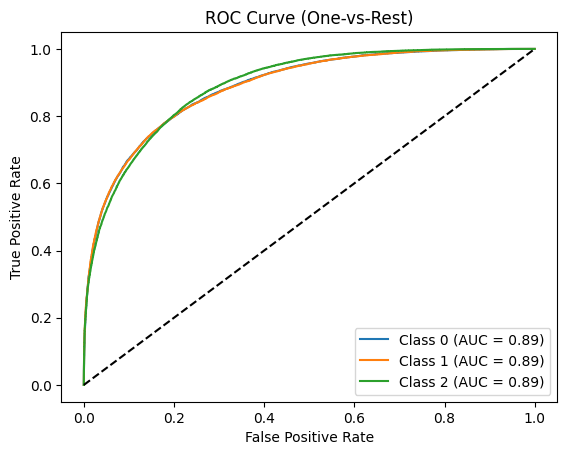

In [28]:
#Evaluate Model
# logloss: The less is better
logloss_xgb = log_loss(y_train, y_train_proba)
print(f"Logloss: {logloss_xgb:.4f}")

# accuracy
acc_xgb = accuracy_score(y_train, y_train_pred)
print(f"Accuracy: {acc_xgb:.4f}")

# precision / recall / f1-score:
print("Classification Report:")
print(classification_report(y_train, y_train_pred, digits=4))

#confusion matrix
cm_xgb = confusion_matrix(y_train, y_train_pred)

print("Confusion Matrix:")
print(cm_xgb)

labels = ['model_a', 'model_b', 'tie']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


#ROC
n_classes = 3 #len(np.unique(y_train))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_train == i).astype(int), y_train_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()



In [29]:
evaluated_model['XGBoost']['logloss'] = logloss_xgb
evaluated_model['XGBoost']['accuracy'] = acc_xgb

evaluated_table=pd.DataFrame(evaluated_model)
evaluated_table

,logistic regression,XGBoost
logloss,0.984516,0.815618
accuracy,0.515545,0.721558


# Cross Validation